In [1]:
# Library imports (see /Utilities/setup_env.py for full import list and figure setup)

from pathlib import Path
import sys

repo_root = Path.cwd().parents[1]  # .../Figure_analysis
repo_root = repo_root.parent       # repo root
sys.path.insert(0, str(repo_root))

from Figure_analysis.Utilities.setup_env import *

In [2]:
mpl.rcParams["lines.linewidth"] = 0.5
mpl.rcParams["axes.linewidth"] = 0.5

mpl.rcParams.update({
    "xtick.major.width": 0.5,
    "ytick.major.width": 0.5,
    "xtick.minor.width": 0.5,
    "ytick.minor.width": 0.5,
})

def thousands(x, pos):
    'The two args are the value and tick position, helper fn'
    return '%1.2f' % (x * 1e3)

# set font size
mpl.rcParams.update({'font.size': 7})

formatter = FuncFormatter(thousands)

In [3]:
nerd_sqlite = '../../../Core_nerd_analysis/nerd.sqlite'

db_path = Path(nerd_sqlite).expanduser().resolve()
if not db_path.exists():
    raise FileNotFoundError(f"Database not found: {db_path}")

conn = sqlite3.connect(db_path)
conn.row_factory = sqlite3.Row

def read_sql(query: str, params: dict | None = None) -> pd.DataFrame:
    """Run a SQL query against the configured database and return a DataFrame."""
    return pd.read_sql_query(query, conn, params=params or {})

In [4]:
# Load all fit parameters for round3_constrained modrate fits
fit_params_df = read_sql(
    """
    WITH run AS (
        SELECT
            r.id  AS fit_run_id,
            r.rg_id
        FROM probe_tc_fit_runs r
        WHERE r.fit_kind = 'round2_global'
    )
    SELECT
        r.rg_id,
        MIN(pr.temperature) AS temperature,
        MAX(mc.disp_name)   AS disp_name,

        MAX(CASE WHEN p.param_name IN ('log_kdeg','logkdeg')
                 THEN p.param_numeric END) AS log_kdeg,
        MAX(CASE WHEN p.param_name IN ('log_kdeg_err','logkdeg_err')
                 THEN p.param_numeric END) AS log_kdeg_err,
        MAX(CASE WHEN p.param_name = 'qc:r2'
                 THEN p.param_numeric END) AS r2

    FROM probe_tc_fit_params p
    JOIN run r              ON r.fit_run_id = p.fit_run_id
    JOIN probe_reactions pr ON pr.rg_id      = r.rg_id
    JOIN meta_constructs mc ON mc.id         = pr.construct_id

    GROUP BY r.fit_run_id, r.rg_id
    """
    )

# # Preprocess k_vals to get k_add-like values
# fit_params_df.loc[:, 'inv_temp'] = 1/(273.15 + fit_params_df['temperature'])
# conc_DMS = 0.015852692  # in M, 1.5% v/v
# # log_kobs in nerd is kappa for now, need to correct later
# # new log_kobs below is K/K+1 kadd [P]_0
# fit_params_df.loc[:, 'log_kobs'] = fit_params_df['log_kobs'] + fit_params_df['log_kdeg'] - np.log(conc_DMS) # adjust for 1.564 mM DMS
fit_params_df = fit_params_df[fit_params_df['temperature'] < 85]
fit_params_df['method'] = 'prime'

In [5]:
# Load all fit parameters for round3_constrained modrate fits
nmr_deg_fit_params_df = read_sql(
    """
    WITH run AS (
        SELECT
            r.id   AS fit_run_id,
            r.species,
            nr.temperature,
            nr.replicate
        FROM nmr_fit_runs r
        JOIN nmr_fit_params p_model
        ON p_model.fit_run_id = r.id
        AND p_model.param_name = 'model'
        AND p_model.param_text = 'lmfit_deg'
        JOIN nmr_reactions nr
        ON nr.id = r.nmr_reaction_id
    )
    SELECT
        r.species,
        r.temperature,
        r.replicate,

        MAX(CASE WHEN TRIM(p.param_name) IN ('k_value','k','k_obs')
                THEN p.param_numeric END) AS k_value,

        MAX(CASE WHEN TRIM(p.param_name) IN ('k_error','k_err','k_sigma')
                THEN p.param_numeric END) AS k_error,

        MAX(CASE WHEN TRIM(p.param_name) IN ('r2','qc:r2','diag:r2')
                THEN p.param_numeric END) AS r2

    FROM run r
    JOIN nmr_fit_params p
    ON p.fit_run_id = r.fit_run_id

    GROUP BY
        r.fit_run_id,
        r.species,
        r.temperature,
        r.replicate;
    """
    )

nmr_deg_fit_params_df['log_kdeg'] = np.log(nmr_deg_fit_params_df['k_value'])
nmr_deg_fit_params_df['log_kdeg_err'] = nmr_deg_fit_params_df['k_error'] / nmr_deg_fit_params_df['k_value']
nmr_deg_fit_params_df['inv_temp'] = 1/(273.15 + nmr_deg_fit_params_df['temperature'])
nmr_deg_fit_params_df['method'] = 'nmr'

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


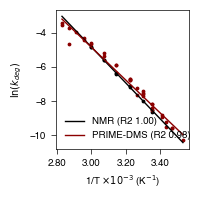

In [11]:
def linear_fit(df_kdeg):
    model = LinearModel()
    params = model.make_params()
    deg_result = model.fit(df_kdeg['log_kdeg'], params, x=df_kdeg['inv_temp'])
    return deg_result

# globally fitted kdeg vals - assessment of global fits
kdeg_curve = fit_params_df[fit_params_df['disp_name'].isin(['4U_wt'])]
kdeg_curve = kdeg_curve[['log_kdeg', 'temperature', 'disp_name']].drop_duplicates()
kdeg_curve['inv_temp'] = 1/(273.15 + kdeg_curve['temperature'])
kdeg_curve['log_kdeg'] = kdeg_curve['log_kdeg']

fourU_result = linear_fit(kdeg_curve)
nmr_result = linear_fit(nmr_deg_fit_params_df)

# calc best fit
x_range = np.array([min(kdeg_curve['inv_temp'].min(), nmr_deg_fit_params_df['inv_temp'].min()), 
                    max(kdeg_curve['inv_temp'].max(), nmr_deg_fit_params_df['inv_temp'].max())])
fourU_bestfit = fourU_result.eval(x = x_range)
nmr_bestfit = nmr_result.eval(x = x_range)

# get r2 values
r2_fourU = fourU_result.rsquared
r2_nmr = nmr_result.rsquared

fig, ax = plt.subplots(figsize = (2, 2))
ax.scatter(x = nmr_deg_fit_params_df['inv_temp'], y = nmr_deg_fit_params_df['log_kdeg'], s=3, color = 'black')
ax.plot(x_range, nmr_bestfit, color = 'black', linewidth = 1, label = f'NMR (R2 {r2_nmr:.2f})')
ax.scatter(x = kdeg_curve['inv_temp'], y = kdeg_curve['log_kdeg'], s=3, color = 'darkred')
ax.plot(x_range, fourU_bestfit, color = 'darkred', linewidth = 1, label = f'PRIME-DMS (R2 {r2_fourU:.2f})')
formatter = FuncFormatter(thousands)
ax.xaxis.set_major_formatter(formatter)
ax.set_ylabel(r'$\ln(k_{deg})$')
ax.set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
ax.legend(frameon = False)
plt.tight_layout()
plt.savefig('lnkdeg_arrhenius.pdf')
plt.show()

nmr_deg_fit_params_df.to_csv('nmr_kdeg.csv')
kdeg_curve.to_csv('fourU_global_kdeg.csv')

In [10]:
kdeg_curve

,log_kdeg,temperature,disp_name,inv_temp
0,-6.306797,30.0,4U_a8c,0.003299
1,-7.248490,33.0,4U_wt,0.003266
2,-7.624853,33.0,4U_wt,0.003266
3,-6.717832,37.0,4U_wt,0.003224
4,-8.146383,25.0,4U_wt,0.003354
...,...,...,...,...
102,-6.344416,45.0,4U_a8c,0.003143
103,-7.438877,30.0,4U_a8c,0.003299
104,-6.001566,48.0,4U_a8c,0.003114
105,-7.217173,30.0,4U_a8c,0.003299


In [12]:
def extract_arrhenius_params(out, label):
    """Extract Arrhenius parameters from lmfit output."""

    R_kcal_per_mol_K = constants.R / constants.calorie / 1000  # kcal/(mol·K)

    slope = out.params[f'slope'].value
    slope_err = out.params[f'slope'].stderr
    intercept = out.params[f'intercept'].value
    intercept_err = out.params[f'intercept'].stderr

    ea = -slope * R_kcal_per_mol_K
    ea_err = slope_err * R_kcal_per_mol_K if slope_err is not None else None

    lnA = intercept
    lnA_err = intercept_err

    return {
        'group': label,
        'ea': ea,
        'ea_err': ea_err,
        'lnA': lnA,
        'lnA_err': lnA_err
    }

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


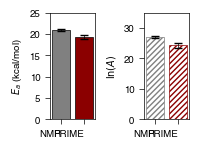

In [13]:
### Bar plot of Arrhenius parameters

# Prepare data
kdeg_arrhenius = pd.DataFrame([
    extract_arrhenius_params(fourU_result, 'prime'),
    extract_arrhenius_params(nmr_result, 'nmr')
    ])

# Map groups to display names and colors
group_labels = {
    'prime': 'PRIME',
    'nmr': 'NMR'
}
colors = {
    'prime': '#8B0000',   # dark red
    'nmr': 'gray',
}

# Set 'group' as the index for easier access
kdeg_arrhenius = kdeg_arrhenius.set_index('group')

# Define group order for plotting
groups = ['nmr', 'prime']
x = range(len(groups))

fig, axs = plt.subplots(1, 2, figsize=(2, 1.5), sharey=False)
          
# Ea bar plot
axs[0].bar(
    x,
    kdeg_arrhenius.loc[groups, 'ea'],
    yerr=kdeg_arrhenius.loc[groups, 'ea_err'],
    capsize=3,
    edgecolor='black',
    linewidth=0.5,
    color=[colors[g] for g in groups]
)
#axs[0].set_title(r'Activation Energy')
axs[0].set_ylabel(r'$E_a$ (kcal/mol)')
axs[0].set_xticks(x)
axs[0].set_xticklabels([group_labels[g] for g in groups], rotation=0, ha='right')

# set ylim 0 to 25
axs[0].set_ylim(0, 25)

# lnA bar plot
axs[1].bar(
    x,
    kdeg_arrhenius.loc[groups, 'lnA'],
    yerr=kdeg_arrhenius.loc[groups, 'lnA_err'],
    capsize=3,
    edgecolor=[colors[g] for g in groups],
    linewidth=0.5,
    hatch="//////",   # diagonal lines
    color='white'
)

# set ylim 0 to 35
axs[1].set_ylim(0, 35)

#axs[1].set_title(r'Pre-exp. Factor')
axs[1].set_ylabel(r'$\ln(A)$')
axs[1].set_xticks(x)
axs[1].set_xticklabels([group_labels[g] for g in groups], rotation=0, ha='right')
plt.tight_layout()
plt.savefig('kdeg_arrhenius_barplot.pdf')
plt.show()

In [15]:
kdeg_arrhenius.to_csv('kdeg_arrhenius_params.csv')